In [ ]:
#import pyrealsense2 as rs
#pipe = rs.pipeline()
#pipe_profile = pipe.start()

#pipe_profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()

In [ ]:
test_mp4, test_depth = None, None

In [77]:
test_mp4, test_depth = "./raw_data/rgb_20250709_000819", "./raw_data/depth_20250709_000819"
#test_mp4, test_depth = 'raw_data/raw_rgb_20250708_170252.mp4','raw_data/raw_depth_20250708_170252.avi'

In [78]:
from video_recorder import VideoRecorder
if test_mp4 is None or test_depth is None:
    rec = VideoRecorder()
    test_mp4, test_depth= rec.process_and_write_from_files("./school_data/Korobka/jpg", "./school_data/Korobka/npy", 400)
    print(f"test_mp4, test_depth = '{test_mp4}','{test_depth}'")


In [79]:
"""import cv2
cap = cv2.VideoCapture(test_mp4)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow('Video', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()"""

"import cv2\ncap = cv2.VideoCapture(test_mp4)\n\nwhile cap.isOpened():\n    ret, frame = cap.read()\n    if not ret:\n        break\n\n    cv2.imshow('Video', frame)\n    if cv2.waitKey(25) & 0xFF == ord('q'):\n        break\n\ncap.release()\ncv2.destroyAllWindows()"

In [80]:
import cv2
from frame_processor import FrameProcessor
from mock_camera import MockCamera

from config import Config 
Config.POINT_CLOUD_STRIDE=1

# Инициализация
Config.CAMERA_INTRINSICS={
                'fx': 390.4425964355469, 
                'fy': 390.4425964355469,
                'cx': 320.0,
                'cy': 240.0,
                'depth_scale': 0.001
            }
Config.MAX_OBSERVATIONS=30
camera_intrinsics = Config.CAMERA_INTRINSICS
#Config.CAMERA_INTRINSICS

camera = MockCamera(rgb_folder=test_mp4, depth_folder=test_depth)
processor = FrameProcessor(camera_intrinsics)
processor.set_tracking_enabled(True)
camera.start()

# Обработка и отображение
while True:
   color, depth = camera.get_frames()
   if color is None or depth is None:
       break
   
   # Обработка кадра
   results = processor.process_frame(color, depth)
   
   # Отображение результата (combined = RGB + Depth + Cleaned)
   cv2.imshow('Processed Video', results['combined'])
   
   # Или только обработанный RGB с масками
   # cv2.imshow('Processed Video', results['color_with_mask'])
   
   if cv2.waitKey(25) & 0xFF == ord('q'):
       break

camera.stop()
cv2.destroyAllWindows()

# Вывод статистики
print(f"Обработано кадров: {processor.frame_count}")
print(f"Отслеживается объектов: {len(processor.tracker.tracked_objects)}")

Object 0: создано облако из 825924 точек на основании 53 масок
Обработано кадров: 80
Отслеживается объектов: 0


In [83]:
import numpy as np
completed_objects = processor.get_completed_objects()
print(f"\nЗавершено объектов: {len(completed_objects)}")

# Анализ результатов
for idx, obj in enumerate(completed_objects):
    print(f"\n Объект №: {idx}")
    print(f"  Точек в облаке: {len(obj['point_cloud'])}")
    print(f"  Всего масок: {len(obj['all_masks'])}")
    print(f"  Выбрано масок: {len(obj['selected_masks'])}")



Завершено объектов: 1

 Объект №: 0
  Точек в облаке: 825924
  Всего масок: 53
  Выбрано масок: 50


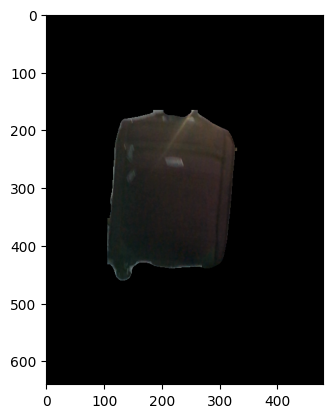

In [85]:
import matplotlib.pyplot as plt
SELECTED_IDX = 0
mask = completed_objects[SELECTED_IDX]['selected_masks'][5]
#mask['rgb_values'].shape
rgb_img = np.zeros((mask['mask'].shape[0], mask['mask'].shape[1], 3), dtype=np.int32)
y_coords, x_coords = np.where(mask['mask'] > 0)
rgb_img[y_coords, x_coords] =mask['rgb_values']
rgb_img.shape
plt.imshow(rgb_img)


In [86]:
def obj_to_frames(completed_objects, selected_idx=0, num_frame=0):
    """Конвертация obj данных в кадры для реконструкции"""
    obj = completed_objects[selected_idx]
    masks = obj['selected_masks']
    
    depth_frames = []
    color_frames = []
    mask_frames = []
    
    # Получаем размеры из первой маски
    first_mask = masks[num_frame]['mask']
    height, width = first_mask.shape
    
    for mask_data in masks:
        mask = mask_data['mask']
        depth_values = mask_data['depth_values']
        rgb_values = mask_data['rgb_values']
        
        # Восстановление depth изображения
        depth_img = np.zeros((height, width), dtype=np.uint16)
        y_coords, x_coords = np.where(mask > 0)
        depth_img[y_coords, x_coords] = depth_values.astype(np.uint16)
        
        # Восстановление RGB изображения
        rgb_img = np.zeros((height, width, 3), dtype=np.uint8)
        rgb_img[y_coords, x_coords] = rgb_values.astype(np.uint8)
        
        # Маска для фильтрации
        binary_mask = (mask > 0).astype(np.uint8)
        
        depth_frames.append(depth_img)
        color_frames.append(rgb_img)
        mask_frames.append(binary_mask)
    
    return depth_frames, color_frames, mask_frames


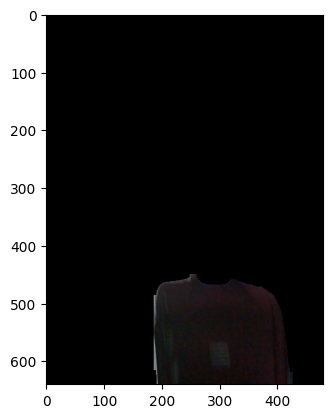

In [87]:
depth_frames, color_frames, mask_frames = obj_to_frames(completed_objects, SELECTED_IDX)
plt.imshow(color_frames[0])
#plt.imshow(depth_frames[0])

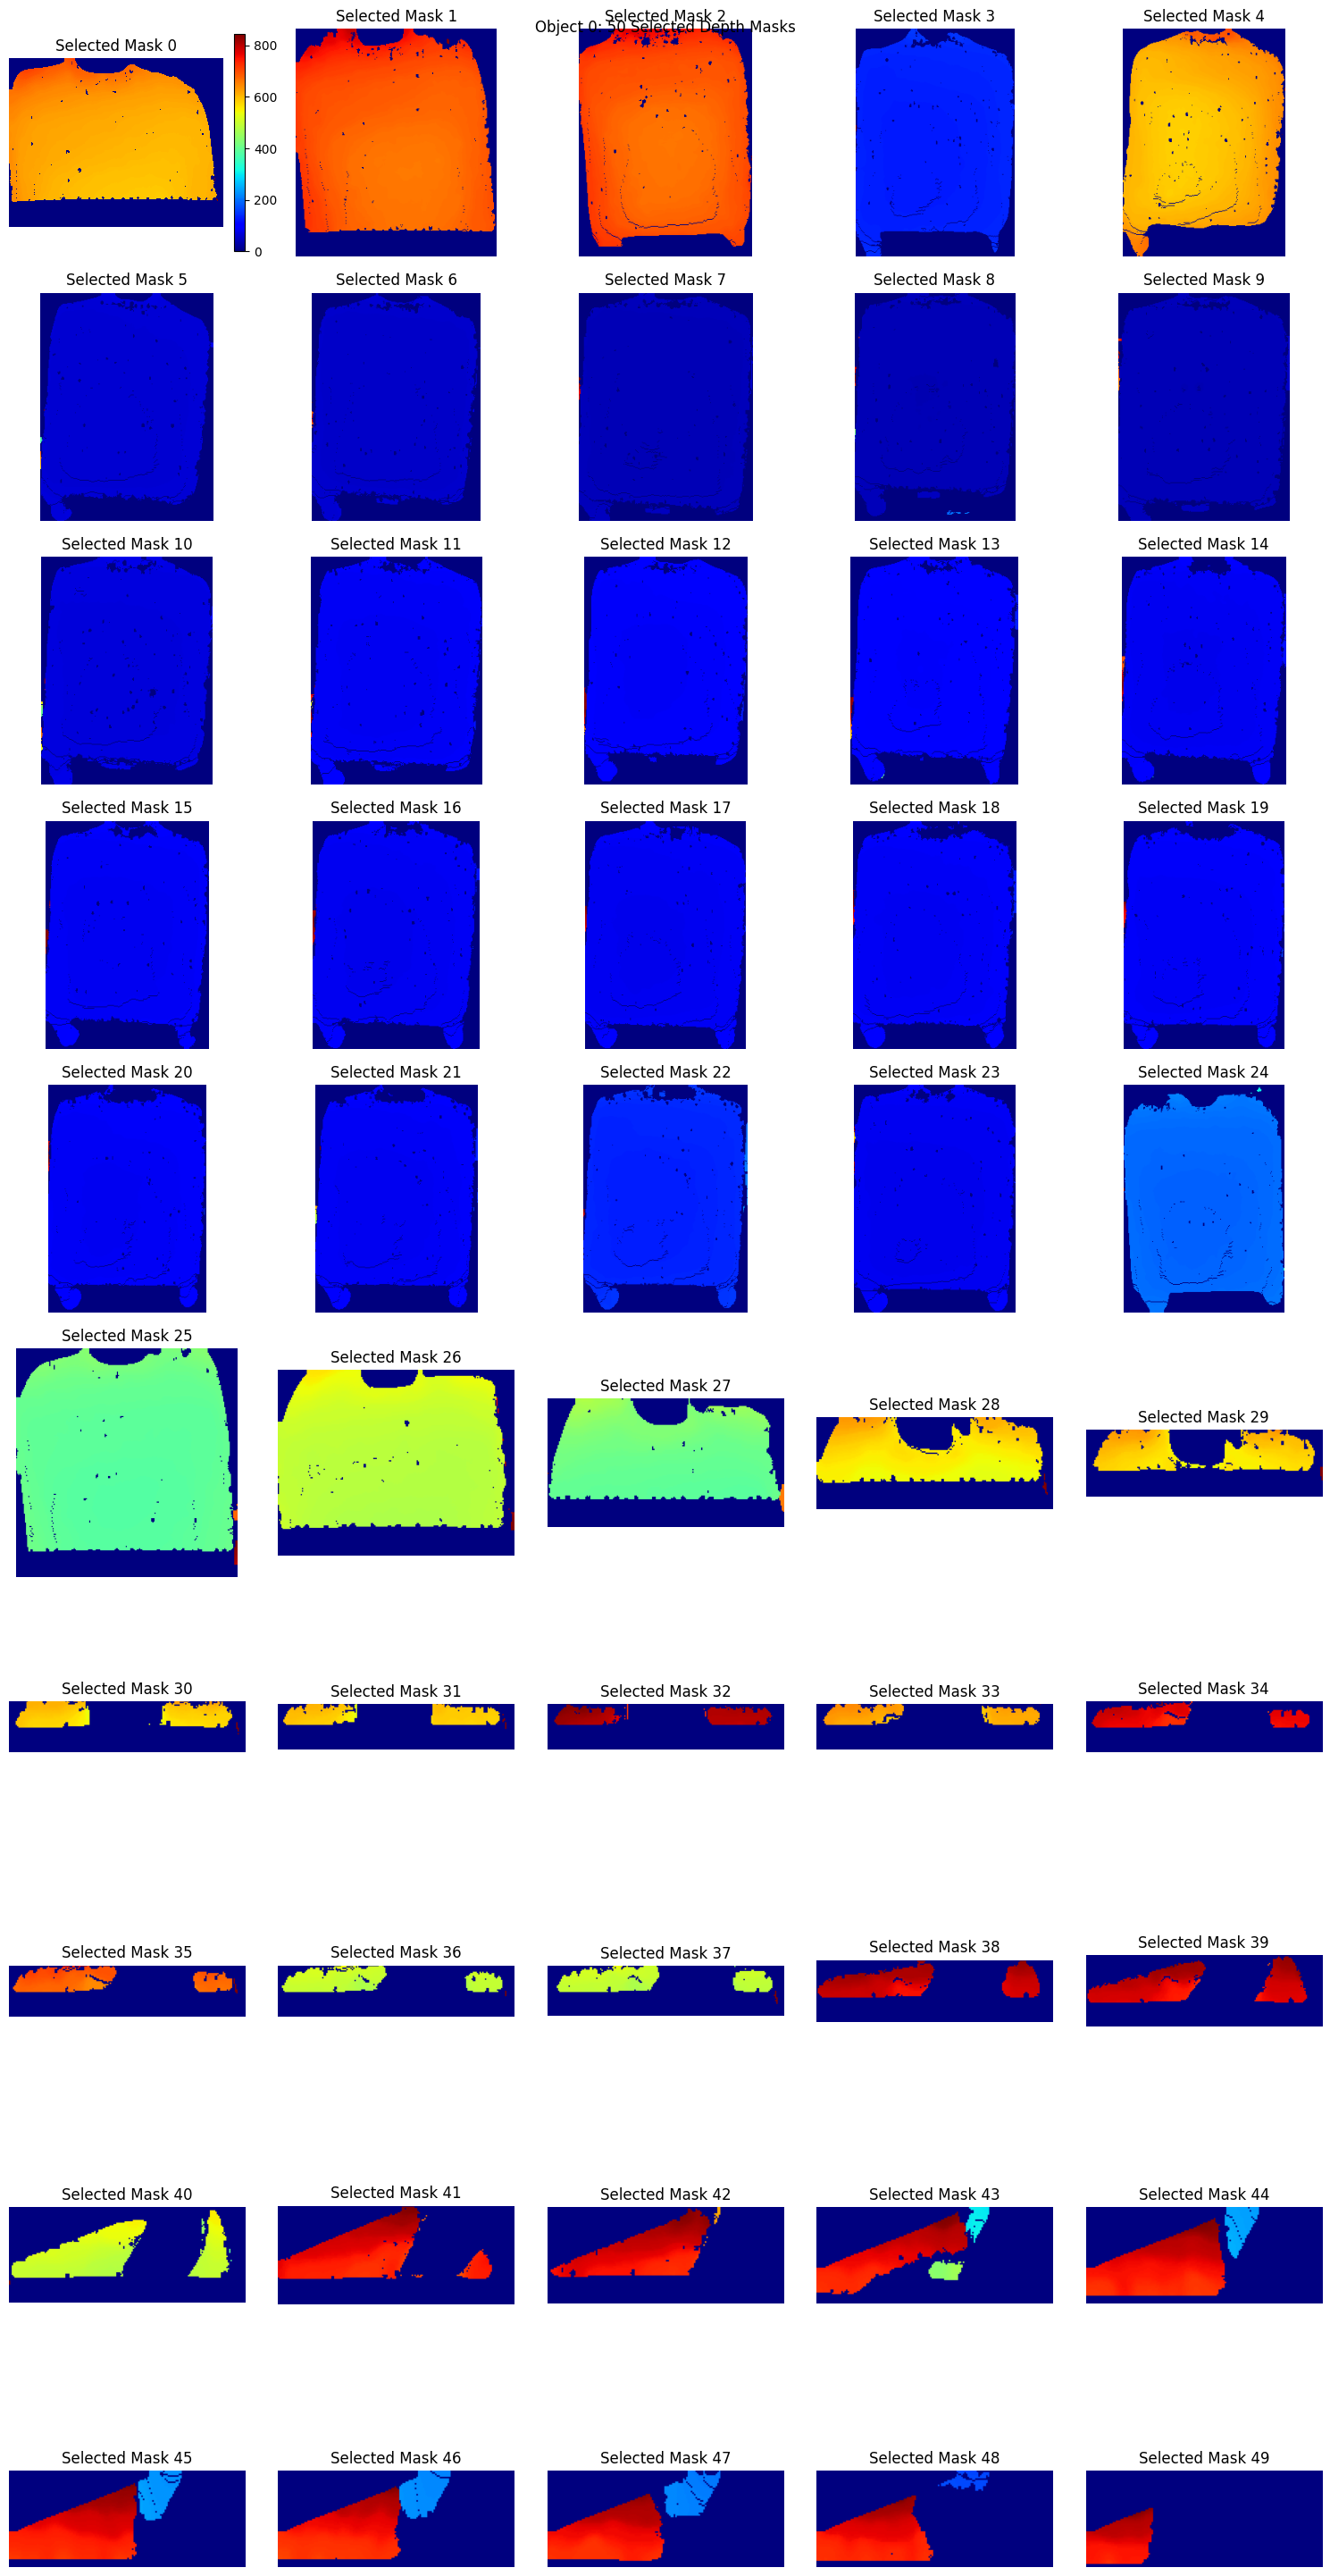

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_depth_masks(obj, show_all=False):
    """Визуализация масок глубины объекта с автоматическим кадрированием"""
    masks_to_show = obj['all_masks'] if show_all else obj['selected_masks']
    n_masks = len(masks_to_show)
    
    cols = min(5, n_masks)
    rows = (n_masks + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.atleast_1d(axes).flatten()

    for i, mask_data in enumerate(masks_to_show):
        if i >= len(axes):
            break

        mask = mask_data['mask']
        depth_values = mask_data['depth_values']
        #print(depth_values[:5])
        #rgb_values = mask_data['rgb_values']

        depth_img = np.zeros_like(mask, dtype=np.float32)
        y_coords, x_coords = np.where(mask > 0)
        depth_img[y_coords, x_coords] = depth_values

        # Находим границы непустой области
        if len(x_coords) > 0 and len(y_coords) > 0:
            x_min, x_max = x_coords.min(), x_coords.max()
            y_min, y_max = y_coords.min(), y_coords.max()

            cropped_img = depth_img[y_min:y_max+1, x_min:x_max+1]
        else:
            cropped_img = depth_img  # если маска пустая

        im = axes[i].imshow(cropped_img, cmap='jet')
        axes[i].set_title(f'{"All" if show_all else "Selected"} Mask {i}')
        axes[i].axis('off')

        # Colorbar только для первого изображения
        if i == 0:
            plt.colorbar(im, ax=axes[i], fraction=0.046)

    # Скрыть пустые subplot'ы
    for i in range(n_masks, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'Object {obj["id"]}: {n_masks} {"All" if show_all else "Selected"} Depth Masks')
    plt.tight_layout()
    plt.show()

# Использование
if completed_objects:
   obj = completed_objects[SELECTED_IDX]
   
   # Показать выбранные маски
   visualize_depth_masks(obj, show_all=False)
   
   # Показать все маски
   #visualize_depth_masks(obj, show_all=True)

In [89]:
import numpy as np
import cv2
import open3d as o3d
import trimesh
from sklearn.cluster import DBSCAN

class LibraryReconstruction:
    def __init__(self, camera_intrinsics):
        self.intrinsics = camera_intrinsics
        self.accumulated_points = []
        
    def depth_to_pointcloud(self, depth_image, color_image):
        """Конвертация depth в point cloud через Open3D"""
        # Проверка и конвертация форматов
        if color_image.dtype != np.uint8:
            color_image = color_image.astype(np.uint8)
        if len(color_image.shape) == 3 and color_image.shape[2] == 3:
            color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        
        if depth_image.dtype != np.uint16:
            depth_image = depth_image.astype(np.uint16)
        
        # Создание изображений Open3D
        color_o3d = o3d.geometry.Image(color_image)
        depth_o3d = o3d.geometry.Image(depth_image)
        
        # Создание RGBD изображения
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color_o3d, depth_o3d, 
            depth_scale=1000.0,  # Масштаб для миллиметров
            depth_trunc=3.0,     # Максимальная глубина в метрах
            convert_rgb_to_intensity=False
        )
        
        # Параметры камеры
        intrinsic = o3d.camera.PinholeCameraIntrinsic(
            width=color_image.shape[1],
            height=color_image.shape[0],
            fx=self.intrinsics['fx'],
            fy=self.intrinsics['fy'],
            cx=self.intrinsics['cx'],
            cy=self.intrinsics['cy']
        )
        
        # Создание point cloud
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
        
        return pcd
    
    def reconstruct_with_open3d(self, depth_frames, color_frames):
        """Реконструкция через Open3D TSDF"""
        volume = o3d.pipelines.integration.ScalableTSDFVolume(
            voxel_length=0.01,  # 1cm вокселы
            sdf_trunc=0.04,     # Truncation distance
            color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8
        )
        
        intrinsic = o3d.camera.PinholeCameraIntrinsic(
            width=color_frames[0].shape[1],
            height=color_frames[0].shape[0],
            fx=self.intrinsics['fx'],
            fy=self.intrinsics['fy'],
            cx=self.intrinsics['cx'],
            cy=self.intrinsics['cy']
        )
        
        for i, (depth, color) in enumerate(zip(depth_frames, color_frames)):
            # Правильная конвертация форматов
            if color.dtype != np.uint8:
                color = color.astype(np.uint8)
            if len(color.shape) == 3 and color.shape[2] == 3:
                # BGR -> RGB для Open3D
                color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
            
            # Depth должен быть uint16 или float32
            if depth.dtype == np.uint16:
                depth_o3d = o3d.geometry.Image(depth)
            else:
                depth_o3d = o3d.geometry.Image(depth.astype(np.uint16))
            
            color_o3d = o3d.geometry.Image(color)
            
            rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
                color_o3d, depth_o3d,
                depth_scale=1000.0,
                depth_trunc=3.0,
                convert_rgb_to_intensity=False
            )
            
            # Простая траектория (можно заменить на SLAM)
            extrinsic = np.eye(4)
            extrinsic[2, 3] = i * 0.01  # Небольшое смещение
            
            volume.integrate(rgbd, intrinsic, extrinsic)
        
        # Извлечение меша
        mesh = volume.extract_triangle_mesh()
        mesh.compute_vertex_normals()
        
        return mesh
    
    def reconstruct_with_trimesh(self, point_clouds):
        """Реконструкция через Trimesh (Poisson)"""
        # Объединение всех точек
        all_points = []
        all_colors = []
        
        for pcd in point_clouds:
            points = np.asarray(pcd.points)
            colors = np.asarray(pcd.colors)
            all_points.append(points)
            all_colors.append(colors)
        
        combined_points = np.vstack(all_points)
        combined_colors = np.vstack(all_colors)
        
        # Создание Trimesh point cloud
        cloud = trimesh.PointCloud(combined_points, combined_colors)
        
        # Poisson реконструкция
        try:
            mesh = cloud.convex_hull  # Простая версия
            # Для более сложной реконструкции нужен дополнительный код
            return mesh
        except:
            return None
    
    def process_moving_object(self, depth_frames, color_frames, masks=None):
        """Обработка движущегося объекта"""
        reconstructed_meshes = []
        
        for i, (depth, color) in enumerate(zip(depth_frames, color_frames)):
            # Применение маски если есть
            if masks and i < len(masks):
                depth_masked = depth * masks[i]
                color_masked = color * masks[i][:, :, np.newaxis]
            else:
                depth_masked = depth
                color_masked = color
            
            # Создание point cloud для текущего кадра
            pcd = self.depth_to_pointcloud(depth_masked, color_masked)
            
            # Фильтрация выбросов
            pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
            
            # Кластеризация для выделения объектов
            points = np.asarray(pcd.points)
            if len(points) > 0:
                clustering = DBSCAN(eps=0.05, min_samples=10).fit(points)
                labels = clustering.labels_
                
                # Берем самый большой кластер
                if len(np.unique(labels)) > 1:
                    largest_cluster = np.argmax(np.bincount(labels[labels >= 0]))
                    mask = labels == largest_cluster
                    pcd = pcd.select_by_index(np.where(mask)[0])
            
            reconstructed_meshes.append(pcd)
        
        return reconstructed_meshes


In [90]:
import plotly.graph_objects as go
import numpy as np

def plot_comparison_plotly(mesh, point_cloud):
    """Сравнение облака точек и меша рядом"""
    from plotly.subplots import make_subplots
    
    # Создаем subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scatter3d'}, {'type': 'mesh3d'}]],
        subplot_titles=('Original Point Cloud', 'Reconstructed Mesh')
    )
    if point_cloud is not None:
        # Подвыборка точек
        if len(point_cloud) > 5000:
            idx = np.random.choice(len(point_cloud), 5000, replace=False)
            points = point_cloud[idx]
        else:
            points = point_cloud
    
        
        # Облако точек
        fig.add_trace(
            go.Scatter3d(
                x=points[:, 0],
                y=points[:, 1],
                z=points[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=points[:, 2],
                    colorscale='plasma'
                ),
                showlegend=False
            ),
            row=1, col=1
        )
    
    # Меш
    if mesh is not None:
        vertices = np.asarray(mesh.vertices)
        triangles = np.asarray(mesh.triangles)
        
        fig.add_trace(
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=triangles[:, 0],
                j=triangles[:, 1],
                k=triangles[:, 2],
                opacity=0.7,
                color='lightcoral',
                flatshading=True
            ),
            row=1, col=2
        )
        
    # Общие настройки осей
    axis_settings = dict(
        showbackground=True,
        backgroundcolor="rgb(230, 230, 230)",
        gridcolor="rgb(255, 255, 255)",
        zerolinecolor="rgb(255, 255, 255)"
    )
    
    fig.update_layout(
        scene1=dict(
            xaxis=axis_settings,
            yaxis=axis_settings,
            zaxis=axis_settings,
            aspectmode='data'
        ),
        scene2=dict(
            xaxis=axis_settings,
            yaxis=axis_settings,
            zaxis=axis_settings,
            aspectmode='data'
        ),
        height=600,
        width=1200
    )
    
    fig.show()


In [91]:
reconstructor = LibraryReconstruction(camera_intrinsics)
pcl = reconstructor.depth_to_pointcloud(depth_frames[5], color_frames[5])
plot_comparison_plotly(None, np.asarray(pcl.points))


In [92]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_pointcloud_jupyter(pcd, show_bbox=True, point_size=1.0):
    """Визуализация point cloud в Jupyter с plotly"""
    import plotly.graph_objects as go
    import numpy as np
    
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors) if pcd.has_colors() else None
    
    # Создание 3D scatter plot
    if colors is not None and len(colors) > 0:
        # Конвертация цветов в формат RGB строк
        colors_rgb = ['rgb({},{},{})'.format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]
        scatter = go.Scatter3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            mode='markers',
            marker=dict(
                size=point_size,
                color=colors_rgb,
                opacity=0.6
            ),
            name='Point Cloud'
        )
    else:
        scatter = go.Scatter3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            mode='markers',
            marker=dict(
                size=point_size,
                opacity=0.6
            ),
            name='Point Cloud'
        )
    
    data = [scatter]
    
    # Добавление oriented bounding box
    if show_bbox:
        bbox = pcd.get_oriented_bounding_box()
        corners = np.asarray(bbox.get_box_points())
        
        edges = [
            [0, 1], [1, 3], [3, 2], [2, 0],  # нижняя грань
            [4, 5], [5, 7], [7, 6], [6, 4],  # верхняя грань
            [0, 4], [1, 5], [2, 6], [3, 7]   # вертикальные ребра
        ]
        
        for edge in edges:
            edge_points = corners[edge]
            line = go.Scatter3d(
                x=edge_points[:, 0], y=edge_points[:, 1], z=edge_points[:, 2],
                mode='lines',
                line=dict(color='red', width=4),
                showlegend=False
            )
            data.append(line)
    
    # Создание фигуры
    fig = go.Figure(data=data)
    
    fig.update_layout(
        title='Point Cloud with Bounding Box',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        width=800,
        height=600
    )
    
    fig.show()

def get_bbox_parameters(pcd):
    """Получение параметров oriented bounding box"""
    # Oriented bounding box
    obb = pcd.get_oriented_bounding_box()
    
    # Вычисление размеров из extent
    width = obb.extent[0]
    height = obb.extent[1]
    depth = obb.extent[2]
    
    # Центр
    center = obb.center
    
    # Объем
    volume = width * height * depth
    
    print("=== ORIENTED BOUNDING BOX ===")
    print(f"Center: [{center[0]:.4f}, {center[1]:.4f}, {center[2]:.4f}]")
    print(f"Dimensions (W×H×D): {width:.4f} × {height:.4f} × {depth:.4f}")
    print(f"Volume: {volume:.6f}")
    print(f"Extent: [{obb.extent[0]:.4f}, {obb.extent[1]:.4f}, {obb.extent[2]:.4f}]")
    print(f"Rotation matrix:\n{obb.R}")
    
    return {
        'center': center,
        'dimensions': [width, height, depth],
        'volume': volume,
        'extent': obb.extent,
        'rotation': obb.R
    }

In [96]:
#visualize_pointcloud_jupyter(pcl, show_bbox=True)
mesh_coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0.45])
OBB = pcl.get_oriented_bounding_box()
OBB.color = [1, 0, 0]
o3d.visualization.draw_geometries([mesh_coord_frame, pcl, OBB])
get_bbox_parameters(pcl)

=== ORIENTED BOUNDING BOX ===
Center: [-0.1851, 0.1461, 0.7882]
Dimensions (W×H×D): 0.5929 × 0.3901 × 0.2819
Volume: 0.065208
Extent: [0.5929, 0.3901, 0.2819]
Rotation matrix:
[[   -0.12951    -0.99009   -0.054313]
 [    0.99154    -0.12884   -0.015589]
 [  0.0084364   -0.055873      0.9984]]


{'center': array([   -0.18512,     0.14613,     0.78823]),
 'dimensions': [np.float64(0.5929282692156987),
  np.float64(0.39012436185158283),
  np.float64(0.2819007379329411)],
 'volume': np.float64(0.06520808418698962),
 'extent': array([    0.59293,     0.39012,      0.2819]),
 'rotation': array([[   -0.12951,    -0.99009,   -0.054313],
        [    0.99154,    -0.12884,   -0.015589],
        [  0.0084364,   -0.055873,      0.9984]])}

In [95]:
obj= completed_objects[SELECTED_IDX]
plot_comparison_plotly(None, processor.reconstructor.reconstruct_from_masks([obj['selected_masks'][1]]))
#processor.reconstructor.reconstruct_from_masks(obj['selected_masks'][:3])

In [ ]:
obj = completed_objects[SELECTED_IDX]

if obj.get('mesh'):
    plot_comparison_plotly(obj['mesh'], obj['point_cloud'])
else:
    # Если меша нет, создаем его
    obj['mesh'] = processor.reconstructor.create_mesh(obj['point_cloud'])
    if obj['mesh']:
        plot_comparison_plotly(obj['mesh'], obj['point_cloud'])